In [13]:
import os
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso

We want to build a LASSO (or an elastic net) model with AAindex1 inputs (averaged over the 5 residues) as input and binding free energies for ACT and FEN as output predictions. This should tell us how important each physicochemical property is.

Also we want to measure how accurate the GP is in predicting __training__ data and data it hasn't seen. We can then compare what's what

In [2]:
def load_json_res(pcc, data_dir):
    with open(f"{data_dir}/{pcc}_FEN.JSON") as f:
        rep = json.load(f)
    F_fen = rep["FE"]
    F_fen_err = rep["FE_error"]

    with open(f"{data_dir}/{pcc}_DEC.JSON") as f:
        rep = json.load(f)
    F_dec = rep["FE"]
    F_dec_err = rep["FE_error"]
    return {"PCC": [rep["PCC"]], "F_FEN": [float(F_fen)], "err_FEN": [float(F_fen_err)],
             "F_DEC": [float(F_dec)], "err_DEC": [float(F_dec_err)]}

def load_data(data_dir):
    PCC_list = []
    for folder in os.listdir(data_dir):
        if re.match("[A-Z]{5}_[A-Z]{3}", folder):
            PCC_list.append(folder.split("_")[0])

    PCC_list = set(PCC_list)
    data = []
    for pcc in PCC_list:
        try:
            data.append(pd.DataFrame(load_json_res(pcc, data_dir)))
        except:
            print(f"Skipping {pcc}.")

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

In [3]:
dataset = load_data("../MD_results")
AAindex1 = pd.read_csv("./AAindex1.csv", index_col=0)

In [4]:
lasso_data = {"PCC": []}
for pp in AAindex1.property:
    lasso_data[pp] = []

In [5]:
for pcc in dataset.PCC:
    lasso_data["PCC"].append(pcc)
    for pp in AAindex1.property:
        pps = []
        for aa in pcc:
            pps.append(AAindex1[AAindex1.property == pp][aa].values[0])
        nancnt = np.count_nonzero(np.isnan(pps))
        if nancnt == 5:
            lasso_data[pp].append(0.0)
        else:
            lasso_data[pp].append(np.nanmean(pps))

In [6]:
lasso_data = pd.DataFrame(lasso_data)
lasso_data.head(10)

,PCC,alpha-CH chemical shifts,Hydrophobicity index,Signal sequence helical potential,Membrane-buried preference parameters,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Average flexibility indices,Residue volume,...,Weighted domination number using the atomic number,Average weighted eccentricity based on the the atomic number,Weighted radius based on the atomic number,Weighted diameter based on the atomic number,Total weighted atomic number of the graph,Average weighted atomic number or degree based on atomic number in the graph,Weighted maximum eigenvalue based on the atomic numbers,Weighted minimum eigenvalue based on the atomic numbers,Weighted average eigenvalue based on the atomic numbers,Weighted second smallest eigenvalue of the weighted Laplacian matrix
0,HGWYW,4.520,1.572,0.546,0.750,0.570,0.770,0.900,0.3794,103.04,...,16.4,21.876,15.0,29.4,49.2000,5.1508,23.8102,-0.4544,10.3244,1.4584
1,GGAGY,4.172,0.540,0.608,0.820,0.498,0.710,0.824,0.4818,55.54,...,5.4,8.856,5.8,12.4,17.8000,4.5440,12.2504,-0.1920,5.7444,0.3198
2,YGVWW,4.384,1.714,0.700,0.920,0.614,0.800,0.824,0.3920,101.68,...,14.6,19.356,12.6,25.6,44.6014,5.4108,23.7616,-0.1076,10.0444,2.3374
3,YSAWW,4.570,1.568,0.816,1.042,0.650,0.738,0.798,0.3788,98.90,...,15.6,20.422,14.0,27.2,45.2000,6.1768,23.9616,-0.1076,10.4778,2.3374
4,PETSE,4.374,0.598,0.558,0.588,0.462,0.606,0.724,0.4908,73.82,...,9.6,15.946,11.2,19.6,30.6000,6.4140,25.0562,-0.8454,10.2002,5.5288
5,YGWWE,4.452,1.544,0.506,0.738,0.596,0.714,0.856,0.4142,101.60,...,15.8,21.456,14.2,28.4,47.8000,5.5448,24.7078,-0.1076,10.3778,1.5018
6,GWGHG,4.248,0.694,0.510,0.646,0.476,0.710,0.926,0.4520,67.24,...,8.4,12.220,7.8,17.0,27.2000,4.1734,15.0042,-0.3046,6.7300,0.7298
7,FTYWD,4.614,1.412,0.802,0.968,0.530,0.812,0.812,0.3988,101.02,...,15.6,21.466,15.2,26.4,46.6000,6.0174,27.4952,-0.9952,11.2744,2.9276
8,YTYHT,4.506,0.894,0.554,0.694,0.472,0.830,0.786,0.4102,93.34,...,12.6,20.692,14.8,27.0,42.6000,5.5880,25.6770,-2.4216,10.5688,3.3606
9,GSANG,4.308,0.172,0.672,0.776,0.480,0.634,0.824,0.4830,51.16,...,5.2,8.566,6.0,11.6,16.2014,5.3860,14.7416,0.0000,6.3334,1.8000


In [7]:
X_fit = []
Y_fit_FEN = []
Y_fit_ACT = []

for pcc in dataset.PCC:
    X_fit.append(lasso_data[lasso_data.PCC == pcc].values[0][1:])
    Y_fit_ACT.append(dataset[dataset.PCC == pcc].F_DEC.values[0])
    Y_fit_FEN.append(dataset[dataset.PCC == pcc].F_FEN.values[0])

X_fit = np.asarray(X_fit)
Y_fit_FEN = np.asarray(Y_fit_FEN).reshape(-1, 1)
Y_fit_ACT = np.asarray(Y_fit_ACT).reshape(-1, 1)

In [8]:
scaler = MinMaxScaler()
X_fit = scaler.fit_transform(X_fit)

# FEN

In [36]:
alpha_list = np.arange(0.1, 1.0, step=0.1)
RMSE_list = []
for alpha in alpha_list:
    clf_FEN = Lasso(alpha=alpha)
    clf_FEN.fit(X_fit, Y_fit_FEN)
    Y_predict = clf_FEN.predict(X_fit)
    RMSE_list.append(np.sqrt((Y_fit_FEN**2 - Y_predict**2).mean()))

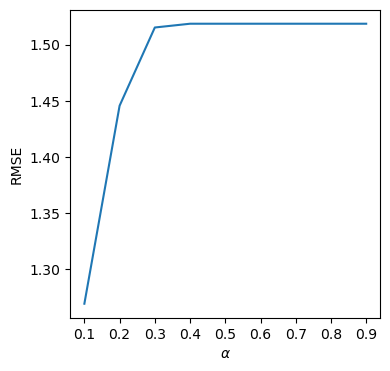

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(alpha_list, RMSE_list)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("RMSE")
ax.set_xticks(alpha_list)
plt.show()

In [38]:
print(Y_fit_FEN.mean())
print(Y_predict.mean())
print(Y_predict.std())

-7.333860802713348
-7.33386080271335
1.7763568394002505e-15


It's regressing to mean past $\alpha$ = 0.4

In [29]:
clf_FEN = Lasso(alpha=0.3)
clf_FEN.fit(X_fit, Y_fit_FEN)

Lasso(alpha=0.3)

In [30]:
nz_coeffs = clf_FEN.coef_.nonzero()[0]
for i in nz_coeffs:
    print(f"{lasso_data.columns[1:][i]}: {clf_FEN.coef_[i]}")

AA composition of CYT of multi-spanning proteins: 0.1578434451386901
Bitterness: -0.20641460833436776


In [20]:
clf_FEN = Lasso(alpha=0.1)
clf_FEN.fit(X_fit, Y_fit_FEN)

Lasso(alpha=0.1)

In [21]:
nz_coeffs = clf_FEN.coef_.nonzero()[0]
for i in nz_coeffs:
    print(f"{lasso_data.columns[1:][i]}: {clf_FEN.coef_[i]}")

AA composition of CYT of multi-spanning proteins: 1.2310031674957354
Bitterness: -0.41619829552710236
Amphiphilicity index: -0.6639233660773742
Apparent partition energies calculated from Robson-Osguthorpe index: 0.770305778760689
Hydropathies of amino acid side chains, pi-values in pH 7.0: -0.03877071297488953


negative Amphiphilicity index mean more hydrophobic residues are prefered for better binding (more negative x means more negative y which is the binding free energy; negative good)
Apparent partition energy is the free energy of transferring a protein from aq solution to a non-polar environment. This is also a measure of hydrophobicity.
Hydropathy pi-values are measures of hydrophibicity (positive more hydrophobic). negative correlation again means more hydrophobic, better binding.

# ACT

In [22]:
alpha_list = np.arange(0.1, 1.0, step=0.1)
RMSE_list = []
for alpha in alpha_list:
    clf_FEN = Lasso(alpha=alpha)
    clf_FEN.fit(X_fit, Y_fit_ACT)
    Y_predict = clf_FEN.predict(X_fit)
    RMSE_list.append(np.sqrt((Y_fit_ACT**2 - Y_predict**2).mean()))

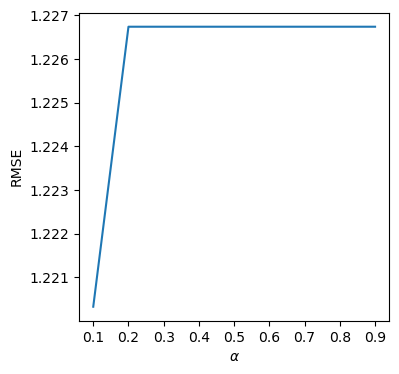

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(alpha_list, RMSE_list)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("RMSE")
ax.set_xticks(alpha_list)
plt.show()

In [34]:
print(Y_fit_ACT.mean())
print(Y_predict.mean())
print(Y_predict.std())

-6.2989231876276355
-6.2989231876276355
0.0


It's regressing to mean past $\alpha$ = 0.2

In [24]:
clf_ACT = Lasso(alpha=0.2)
clf_ACT.fit(X_fit, Y_fit_ACT)

Lasso(alpha=0.2)

In [25]:
nz_coeffs = clf_ACT.coef_.nonzero()[0]
for i in nz_coeffs:
    print(f"{lasso_data.columns[1:][i]}: {clf_ACT.coef_[i]}")